# Inference results visualization

In [256]:
from omegaconf import OmegaConf
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import yaml
from itertools import product

import sys
sys.path.insert(0, '/iopsstor/scratch/cscs/stefschu/DSM500_FPR/supplementary_files/inference')

from lib.utils import build_activities

with open("/iopsstor/scratch/cscs/stefschu/DSM500_FPR/data/FCN_ERA5_data_v0/metadata.yaml", "r") as file:
    meta = yaml.safe_load(file)

def get_format(key):
    global meta
    for entry in meta:
        if entry["key"] == key:
            return entry["tick_format"]
    raise ValueError(f"Key {key} not found in metadata")

## Generate activities list

In [257]:
cfg = OmegaConf.load("/iopsstor/scratch/cscs/stefschu/DSM500_FPR/supplementary_files/inference/conf/config.yaml")
cfg

{'hydra': {'job': {'chdir': False, 'name': 'Inference'}, 'run': {'dir': './outputs/${hydra:job.name}'}}, 'seed': 42, 'models': [{'name': 'gc-baseline-run01', 'type': 'gc', 'code_path': '/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-baseline', 'config_path': '/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-baseline/conf/config.yaml', 'weights': ['/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-baseline/runs/RUN01/SEED21/checkpoint/model.iter003750.pth', '/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-baseline/runs/RUN01/SEED42/checkpoint/model.iter003750.pth', '/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-baseline/runs/RUN01/SEED84/checkpoint/model.iter003750.pth']}, {'name': 'gc-improved-run05', 'type': 'gc', 'code_path': '/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-improved', 'config_path': '/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-improved/conf/config.yaml', 'weights': ['/iopsstor/scratch/cscs/stefschu/DSM500_FPR/modulus-improved/runs/RUN05/SEED2

In [258]:
activities = build_activities(cfg)

print("Activities to run:", len(activities))
print("An activity:", activities[5])

Activities to run: 189
An activity: 
        Activity ID:       5
        Model name:        gc-baseline-run01
        Model type:        gc
        Model weights:     ./DSM500_FPR/modulus-baseline/runs/RUN01/SEED21/checkpoint/model.iter003750.pth
        Initial condition: 275


Verify that all activities have been already processed...

In [259]:
for activity in activities:
    assert activity.is_already_computed()

## Build Pandas dataframe to prepare for seaborn based visualization

In [260]:

container = []
for activity in activities:
    data = torch.load(activity.file_path_metrics, weights_only=False)
    for (variable, region), metrics in data['metrics'].items():
        assert variable == metrics["slice"]["variable"]
        assert region == metrics["slice"]["region"]

        for metric in ["rmse", "acc"]:
            for step in range(cfg.inference.rollout_steps + 1):
                container.append({
                    'activity_id': activity.id,
                    'name': activity.model_name,
                    'type': activity.model_type,
                    'weights': activity.weights_file_path,
                    "ic": activity.dataset_initial_condition_i,
                    'variable': variable,
                    'region': region,
                    'metric': metric,
                    'step': step,
                    'value': metrics[metric][step]
                })

df = pd.DataFrame(container)

# Cleanup
df['weights'] = df['weights'].str.replace('/iopsstor/scratch/cscs/stefschu/DSM500_FPR', '.', regex=False)
df['weights'] = df['weights'].str.replace('/runs', '', regex=False)
df['weights'] = df['weights'].str.replace('/checkpoints', '', regex=False)
df['weights'] = df['weights'].str.replace('/checkpoint', '', regex=False)
df['name'] = df['name'].str.replace('gc-baseline-run01', 'GraphCast-Baseline', regex=False)
df['name'] = df['name'].str.replace('gc-improved-run05', 'GraphCast-Improved', regex=False)
df['name'] = df['name'].str.replace('fourcastnet', 'FourCastNet', regex=False)

# Add count to interpret spread
df["count"] = df.groupby(["name", "variable", "region", "metric", "step"])["step"].transform("count")

df

,activity_id,name,type,weights,ic,variable,region,metric,step,value,count
0,0,GraphCast-Baseline,gc,./modulus-baseline/RUN01/SEED21/model.iter0037...,0,all,global,rmse,0,0.000000,81
1,0,GraphCast-Baseline,gc,./modulus-baseline/RUN01/SEED21/model.iter0037...,0,all,global,rmse,1,1152.000000,81
2,0,GraphCast-Baseline,gc,./modulus-baseline/RUN01/SEED21/model.iter0037...,0,all,global,rmse,2,1288.000000,81
3,0,GraphCast-Baseline,gc,./modulus-baseline/RUN01/SEED21/model.iter0037...,0,all,global,rmse,3,1344.000000,81
4,0,GraphCast-Baseline,gc,./modulus-baseline/RUN01/SEED21/model.iter0037...,0,all,global,rmse,4,1400.000000,81
...,...,...,...,...,...,...,...,...,...,...,...
789259,188,FourCastNet,fcn,./fourcastnet-92260c1/iter3750.pth,1430,v_850,austnz,acc,24,0.420405,27
789260,188,FourCastNet,fcn,./fourcastnet-92260c1/iter3750.pth,1430,v_850,austnz,acc,25,0.294647,27
789261,188,FourCastNet,fcn,./fourcastnet-92260c1/iter3750.pth,1430,v_850,austnz,acc,26,0.236215,27
789262,188,FourCastNet,fcn,./fourcastnet-92260c1/iter3750.pth,1430,v_850,austnz,acc,27,0.085175,27


## Plots production

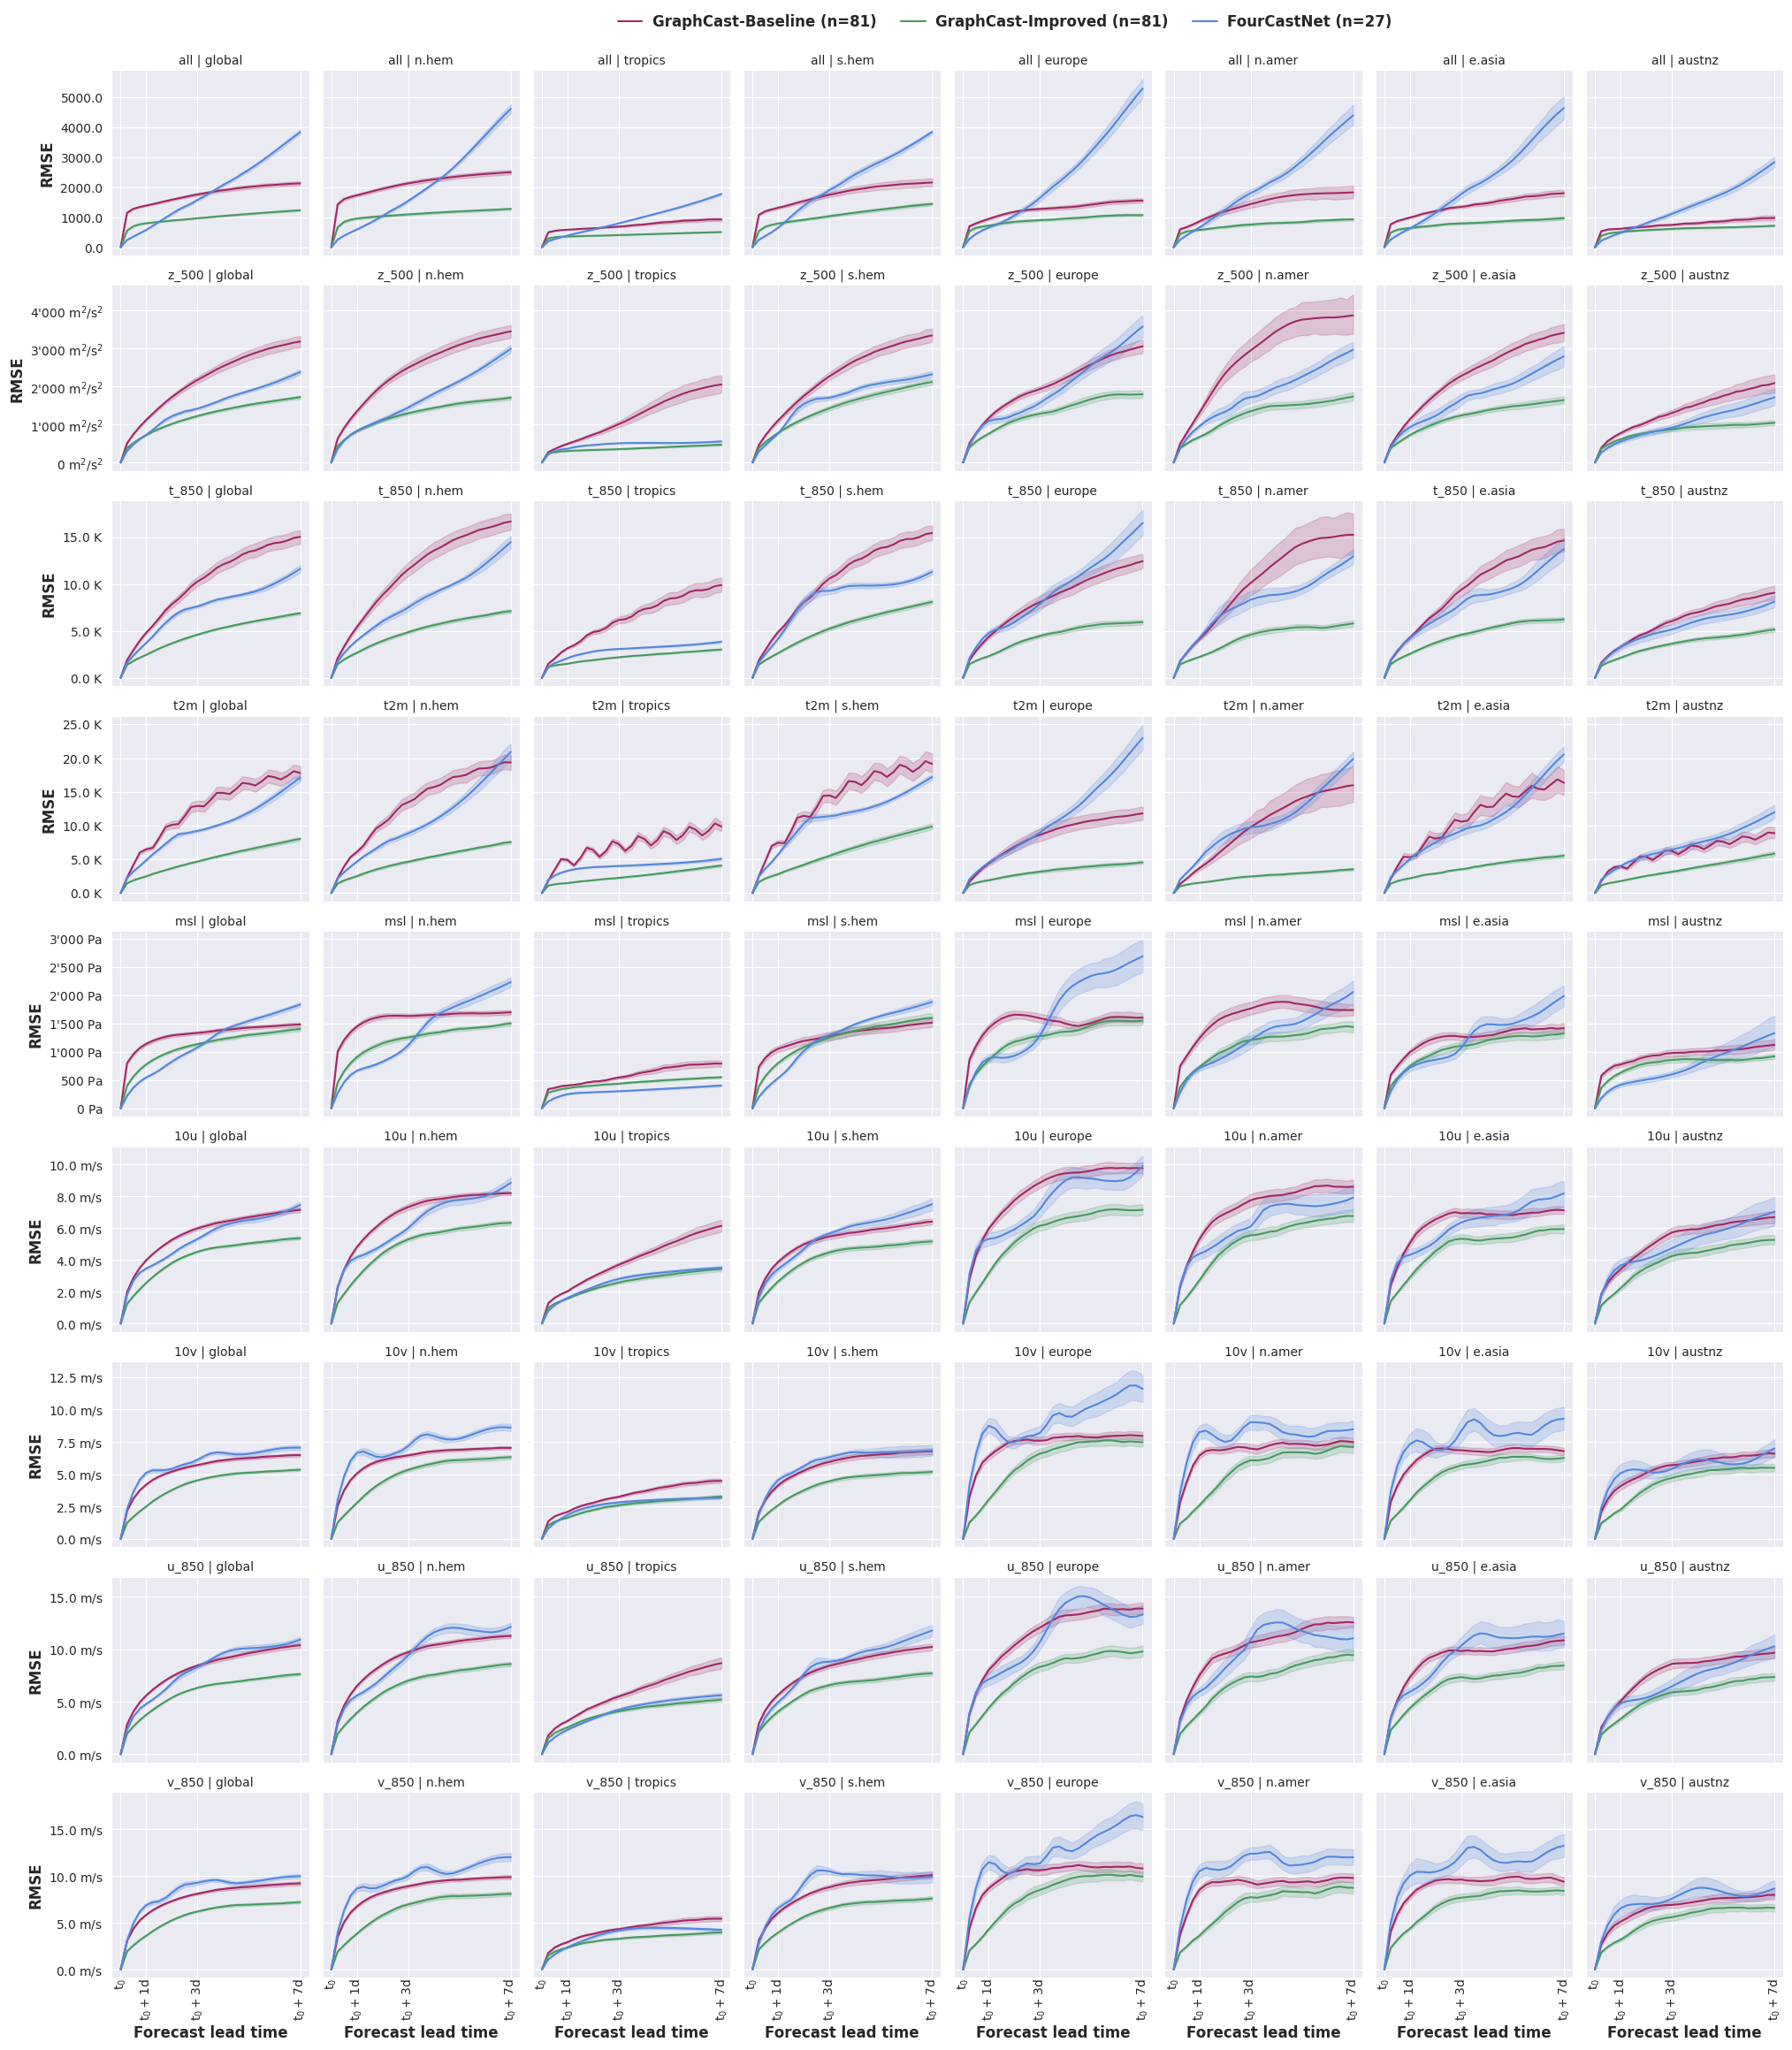

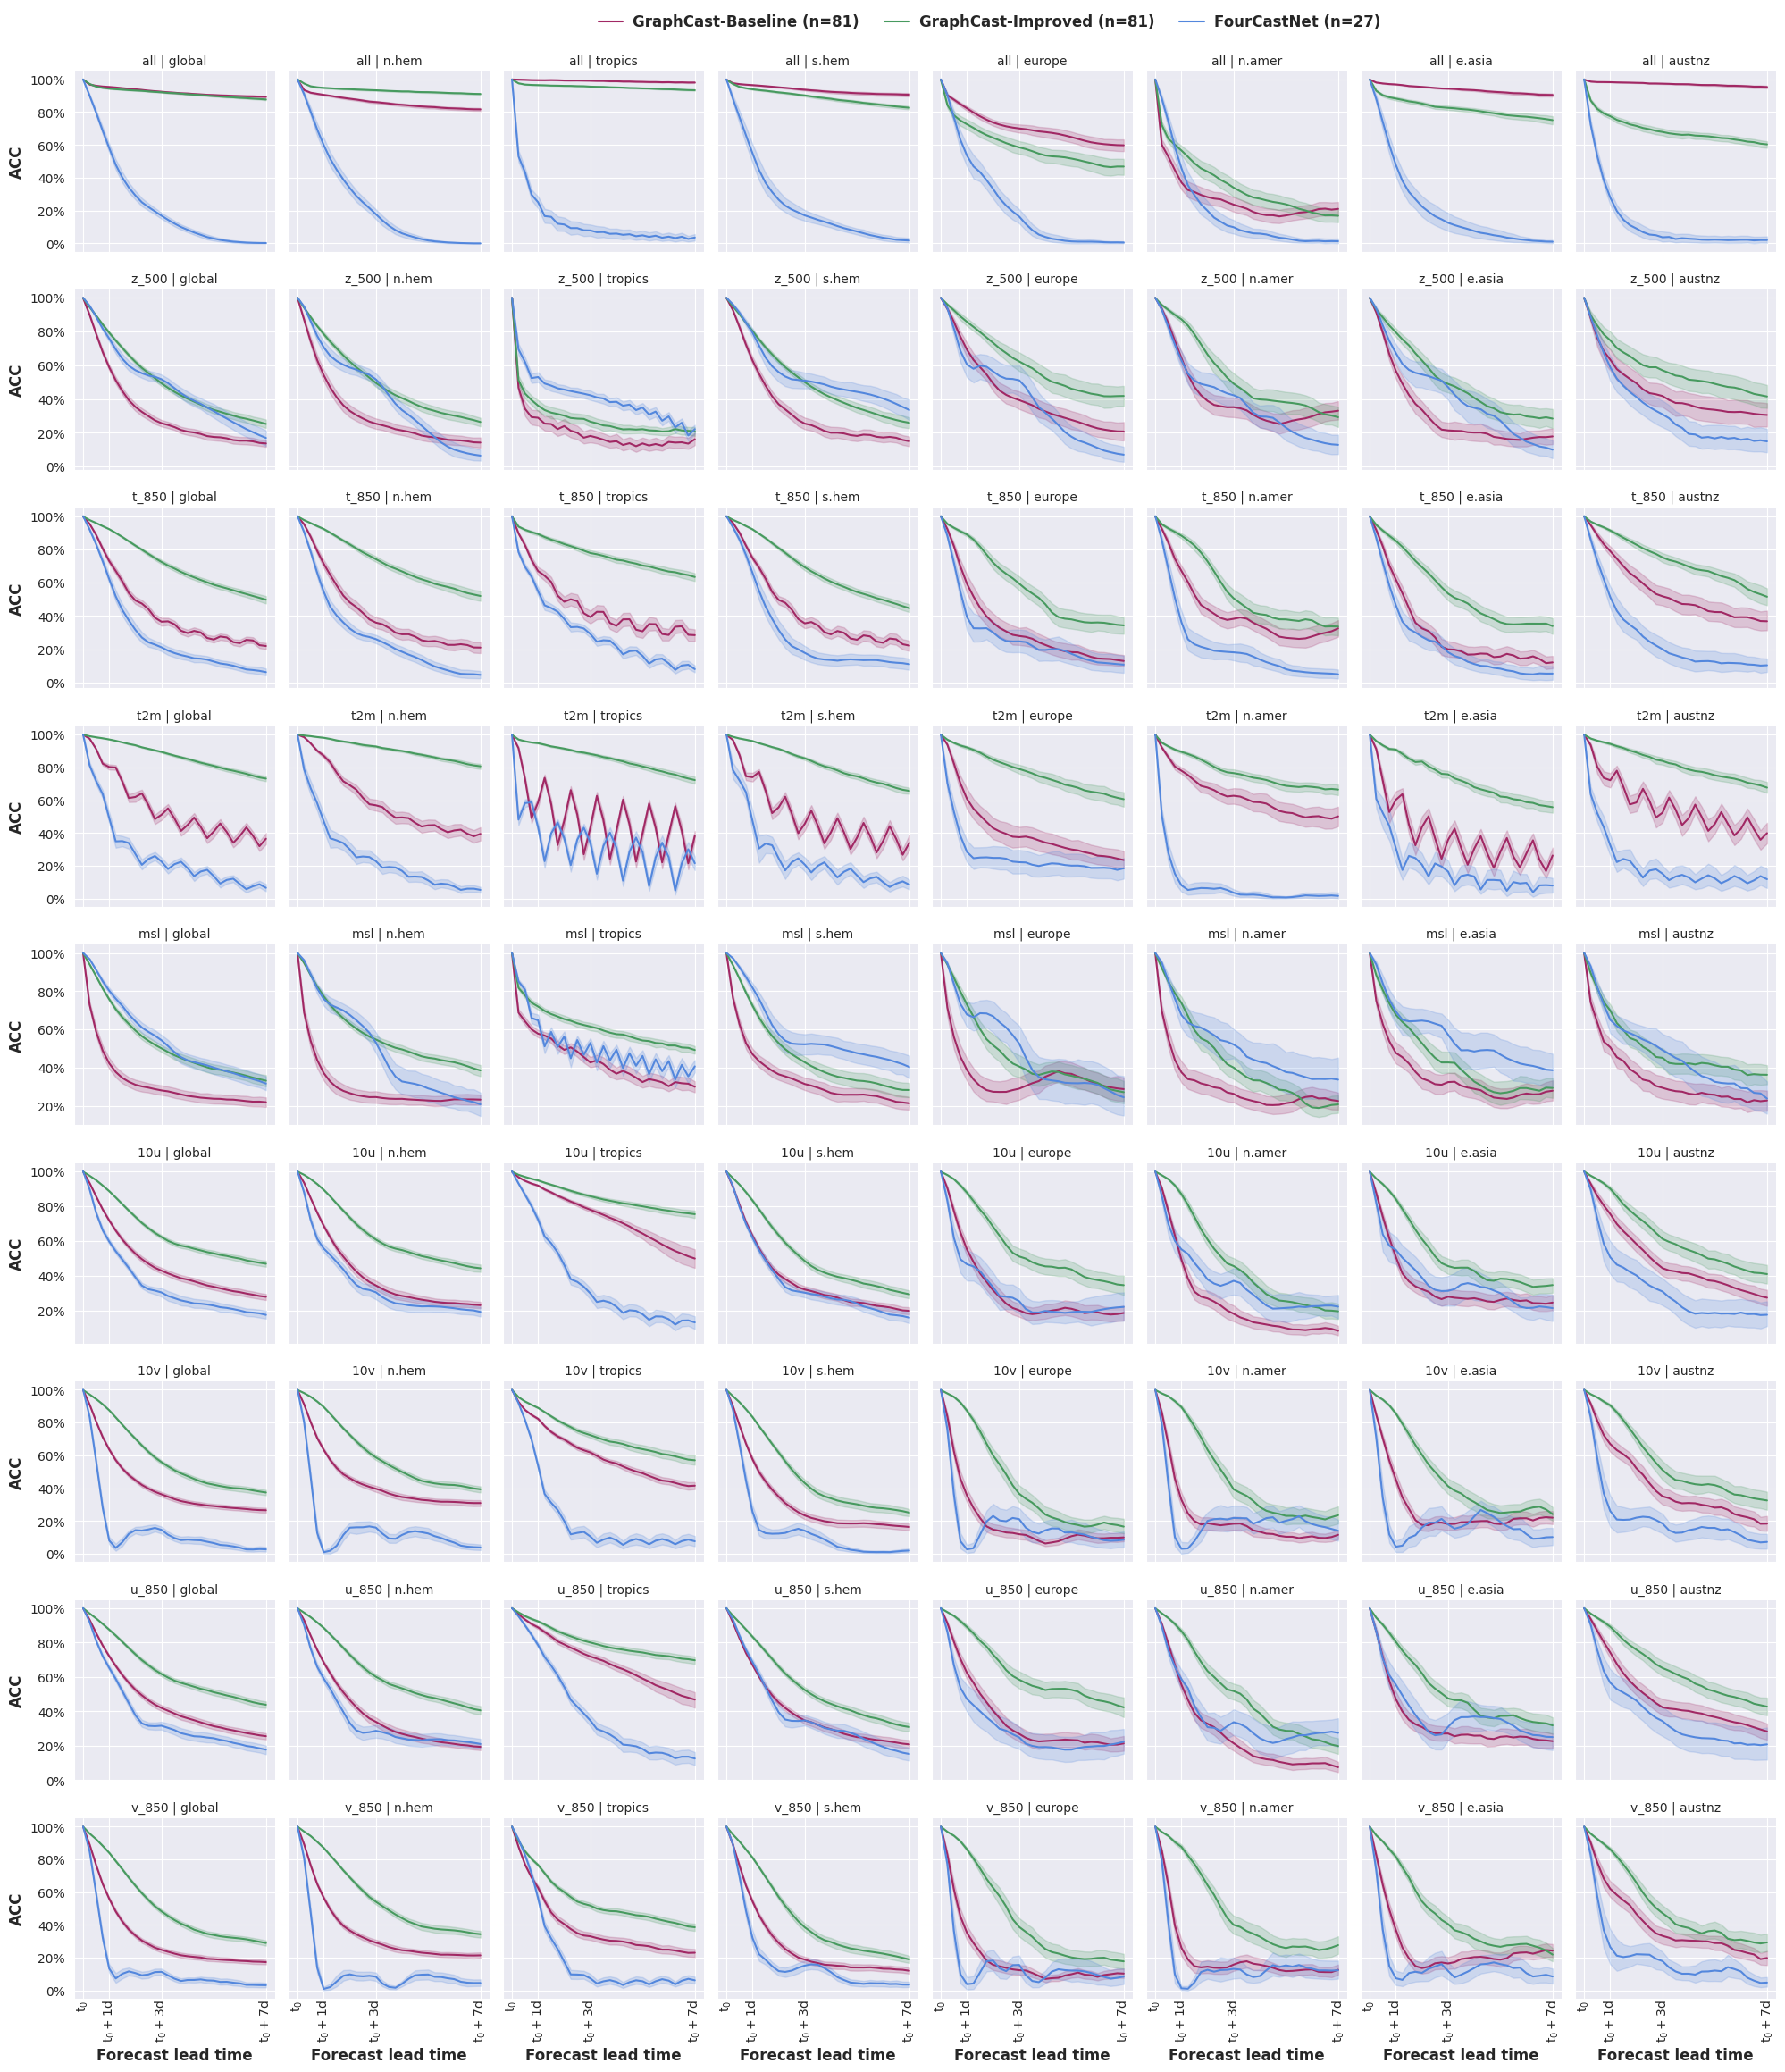

In [6]:
# Select variables and regions of interest
variables_of_interest = df["variable"].unique().tolist()
regions_of_interest = df["region"].unique().tolist()
# Comment / uncomment the following as needed
# variables_of_interest = ['all', 'z_500', 't_850' ,'t2m', 'msl']#, '10u', '10v', 'u_850', 'v_850']
# regions_of_interest = ["global", "n.hem", "tropics", "s.hem", "europe"] #, "austnz"]
filtered_df = df[df["variable"].isin(variables_of_interest) & df["region"].isin(regions_of_interest)]

# Specify custom colors for the models, following the convention that the improved model is green and the red is the baseline. The external reference is provided in green.
custom_colors = {
    "GraphCast-Baseline": "#A12864",
    "FourCastNet": "#5387DD",
    "GraphCast-Improved": "#479A5F" 
}
vertical_grid_lines = {
    "x": [
        0.0, 
        4.0, 
        12.0, 
        28.0,
    ],
    "label": [
        "$\\mathrm{{t_0}}$ ",
        "$\\mathrm{{t_0}}+1$d ",
        "$\\mathrm{{t_0}}+3$d ",
        "$\\mathrm{{t_0}}+7$d ",
    ]
}

# n counts
n_counts_dict = filtered_df[["name", "count"]].drop_duplicates().reset_index(drop=True).set_index("name").to_dict()["count"]

for metric in ["rmse", "acc"]:
    with sns.axes_style("darkgrid"):
        ax = sns.relplot(
            data=filtered_df[filtered_df.metric == metric],
            x="step",
            y="value",
            col="region",
            row="variable",
            hue="name",
            kind="line",
            palette=custom_colors,
            facet_kws={"sharey": "row"},
            height=2.5,
        )

        ax.set_titles(row_template="{row_name}", col_template="{col_name}")
        ax.set_axis_labels("Forecast lead time", metric.upper(), fontsize=12, fontweight='bold')

        legend = sns.move_legend(
            ax, "lower center",
            bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False, prop={'weight': 'bold'}
        )
        for text in ax._legend.get_texts():
            text.set_text(f"{text.get_text()} (n={n_counts_dict[text.get_text()] // (cfg.inference.rollout_steps + 1)})")
            text.set_fontsize(12)

        for i, _ax in enumerate(ax.axes.flatten()):
            _ax.set_xlabel(_ax.get_xlabel(), fontweight='bold', fontsize=12)
            _ax.set_ylabel(_ax.get_ylabel(), fontweight='bold', fontsize=12)
            
            # Y-axis unit formatting
            if metric == "rmse":
                var_id = i // len(regions_of_interest)
                var_key = variables_of_interest[var_id]
                if var_key == "all":
                    _ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda value, _: f"{value:.1f}"))
                else:
                    _format = get_format(var_key)
                    def _formatter(value, _format):
                        number, unit = _format.split(" ")
                        string = number.format(value).replace(",", "'")
                        string = f"{string} $\\mathrm{{{unit}}}$".replace('%', '\%')
                        return string
                    _ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda value, _, _format=_format: _formatter(value, _format)))
            elif metric == "acc":
                _ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

            # Vertical gridlines
            _ax.set_xticks(vertical_grid_lines["x"])
            _ax.set_xticklabels(vertical_grid_lines["label"], rotation=90)

            for label in _ax.get_xticklabels():
                label.set_position((label.get_position()[0], 0.05))

        plt.savefig(f"/iopsstor/scratch/cscs/stefschu/DSM500_FPR/supplementary_files/inference/plots/{metric}.png", dpi=300, bbox_inches="tight") 
        plt.show()

## Quantitative results

In [377]:
df

,activity_id,name,type,weights,ic,variable,region,metric,step,value,count
0,0,GraphCast-Baseline,gc,./modulus-baseline/RUN01/SEED21/model.iter0037...,0,all,global,rmse,0,0.000000,81
1,0,GraphCast-Baseline,gc,./modulus-baseline/RUN01/SEED21/model.iter0037...,0,all,global,rmse,1,1152.000000,81
2,0,GraphCast-Baseline,gc,./modulus-baseline/RUN01/SEED21/model.iter0037...,0,all,global,rmse,2,1288.000000,81
3,0,GraphCast-Baseline,gc,./modulus-baseline/RUN01/SEED21/model.iter0037...,0,all,global,rmse,3,1344.000000,81
4,0,GraphCast-Baseline,gc,./modulus-baseline/RUN01/SEED21/model.iter0037...,0,all,global,rmse,4,1400.000000,81
...,...,...,...,...,...,...,...,...,...,...,...
789259,188,FourCastNet,fcn,./fourcastnet-92260c1/iter3750.pth,1430,v_850,austnz,acc,24,0.420405,27
789260,188,FourCastNet,fcn,./fourcastnet-92260c1/iter3750.pth,1430,v_850,austnz,acc,25,0.294647,27
789261,188,FourCastNet,fcn,./fourcastnet-92260c1/iter3750.pth,1430,v_850,austnz,acc,26,0.236215,27
789262,188,FourCastNet,fcn,./fourcastnet-92260c1/iter3750.pth,1430,v_850,austnz,acc,27,0.085175,27


In [380]:
df_qt = df.copy()

# Keep only steps of interest: 1 day, 3 days, 7 days
df_qt = df_qt[df_qt["step"].isin([4, 12, 28])]

# rename steps column
df_qt["lead_time"] = df_qt["step"].replace({4: "1 day", 12: "3 days", 28: "7 days"})
df_qt = df_qt.drop(columns=["step"])

# Get stats by averaging out both the weight and the initial conditions
df_qt = df_qt.groupby(["name", "variable", "region", "metric", "lead_time"]).agg({"value": ["count", "min", "max", "mean", "std"]}).reset_index()

# Keep only headline metrics
df_qt = df_qt[df_qt["variable"].isin(["all", "z_500", "t_850", "t2m", "msl"])]

# Keep only the regions of interest
df_qt = df_qt[df_qt["region"].isin(["global", "n.hem", "tropics", "s.hem", "europe"])]

# capitalize metrics
df_qt["metric"] = df_qt["metric"].str.upper()

# rename columns
df_qt.columns = ["Model", "Variable", "Region", "Metric", "Lead time", "Count", "Min", "Max", "Mean", "Std"]

# round to visible precision
df_qt["Mean"] = df_qt["Mean"].round(2)
df_qt["Std"] = df_qt["Std"].round(2)

df_qt

,Model,Variable,Region,Metric,Lead time,Count,Min,Max,Mean,Std
108,FourCastNet,all,europe,ACC,1 day,27,0.145795,0.840853,0.53,0.19
109,FourCastNet,all,europe,ACC,3 days,27,0.000000,0.458033,0.16,0.12
110,FourCastNet,all,europe,ACC,7 days,27,0.000000,0.070843,0.01,0.02
111,FourCastNet,all,europe,RMSE,1 day,27,528.170898,767.522644,656.79,68.39
112,FourCastNet,all,europe,RMSE,3 days,27,1122.066650,2423.878418,1648.57,327.76
...,...,...,...,...,...,...,...,...,...,...
1291,GraphCast-Improved,z_500,tropics,ACC,3 days,81,0.000000,0.507812,0.27,0.14
1292,GraphCast-Improved,z_500,tropics,ACC,7 days,81,0.000000,0.439453,0.21,0.11
1293,GraphCast-Improved,z_500,tropics,RMSE,1 day,81,242.000000,386.000000,299.95,31.65
1294,GraphCast-Improved,z_500,tropics,RMSE,3 days,81,272.000000,656.000000,350.52,53.71


In [ ]:
def get_argmax_for_val_column(s, c):
    """
    Get the index of the maximum value in a specific column of a LaTeX table string.
    """
    lines = s.split("\\\\\n")[:-1]
    valmax = sys.float_info.min
    argmax = -1
    for line_i, line in enumerate(lines):
        col = line.split(" & ")[c]
        val = float(col.split(" ± ")[0])
        if val > valmax:
            valmax = val
            argmax = line_i
    return argmax

def get_argmin_for_val_column(s, c):
    """
    Get the index of the minimum value in a specific column of a LaTeX table string.
    """
    lines = s.split("\\\\\n")[:-1]
    valmin = sys.float_info.max
    argmin = -1
    for line_i, line in enumerate(lines):
        col = line.split(" & ")[c]
        val = float(col.split(" ± ")[0])
        if val < valmin:
            valmin = val
            argmin = line_i
    return argmin

def bolden_values_in_group(metric, group):
    """
    Make the values in the group bold according to the metric in use (RMSE mins, ACC maxs).
    """
    separator = "\\\\\n"
    s_orig = group
    s_new = ''
    for row_i, row in enumerate(s_orig.split(separator)[:-1]):
        for col_i, col in enumerate(row.split(" & ")):
            if col_i < 2:
                s_new += col + " & "
            else:
                if metric == "RMSE":
                    arg_i = get_argmin_for_val_column(s_orig, col_i)
                elif metric == "ACC":
                    arg_i = get_argmax_for_val_column(s_orig, col_i)

                if arg_i == row_i:
                    s_new += "\\bfseries " + col.strip() + " & "
                else:
                    s_new += col.strip() + " & "
        s_new = s_new[:-3] + " " + separator
    s_new = s_new.replace("±", "\\pm")
    return s_new

for lt in ["1 day", "3 days", "7 days"]:
    for metric in ["RMSE", "ACC"]:
        # Filter for the current lead time
        _df = df_qt[(df_qt["Lead time"] == lt) & (df_qt["Metric"] == metric)].copy()

        # Make score string for latext presentation
        _df["score"] = _df.apply(lambda row: f"{row['Mean']:.2f} ± {row['Std']:.2f}", axis=1)
        _df = _df[["Model", "Variable", "Region", "Metric", "score"]]

        _table = _df.pivot_table(
            index=["Variable", "Model"],
            columns=["Metric", "Region"],
            values="score",
            aggfunc="first",
        ).reset_index()

        # Order rows
        _table["Model"] = pd.Categorical(_table["Model"], 
            categories=["GraphCast-Baseline", "GraphCast-Improved", "FourCastNet"], 
            ordered=True
        )
        _table["Variable"] = pd.Categorical(_table["Variable"], 
            categories=["all", "z_500", "t_850", "t2m", "msl"], 
            ordered=True
        )
        _table = _table.sort_values(["Variable", "Model"])

        # Fix columns ordering
        ordered_columns = _table.columns[:2].tolist() + list(product([metric], ["global", "n.hem", "tropics", "s.hem", "europe"]))
        _table = _table[ordered_columns]

        # Remove multiindex row names
        _table.index.names = [None] * _table.index.nlevels

        # Get latex
        caption = f"{metric} metric scores (mean ± standard deviation) for {lt} forecast lead time. For \\texttt{{GraphCast-Baseline}} and \\texttt{{GraphCast-Improved}} $n = 81$, and for \\texttt{{FourCastNet}} $n = 27$."
        if metric == "RMSE":
            caption += " Lower values are better. "
        else:
            caption += " Higher values are better."
        label = f"tab:quantitative_{lt}_{metric.lower()}".replace(' ', '_')

        _latex = _table.to_latex(
            index=False,
            caption=caption,
            label=label,
            position="h",
            escape=True,
            multicolumn_format="l"
        )

        # caption and label move below
        _lines = _latex.splitlines()
        caption = _lines[1]
        label = _lines[2]
        _latex = _latex.replace(caption, "")
        _latex = _latex.replace(label, "")
        _latex = _latex.replace("\\begin{table}[h]\n\n\n", "\\begin{table}[h]\n")
        _latex = _latex.replace("\\end{table}\n", f"{caption}\n{label}\n\\end{{table}}\n")

        # Make it fit the width and enable siunitx for uncertainties vertical alignment
        _latex = _latex.replace("\\begin{table}[h]\n", "\\begin{table}[h]\n\\centering\n\\sisetup{separate-uncertainty = true, table-align-uncertainty=true, detect-all=true}\n\\renewrobustcmd{\\bfseries}{\\fontseries{b}\\selectfont}\n\\renewrobustcmd{\\boldmath}{}\n\\begin{adjustbox}{width=\\linewidth}\n")
        _latex = _latex.replace("\\caption", "\\end{adjustbox}\\\\[-0.1cm]\n\\caption")
        if metric == "RMSE":
            _latex = _latex.replace("\\begin{tabular}{lllllll}", "\\begin{tabular}{ll | S[table-format=4.2(5)] S[table-format=4.2(5)] S[table-format=4.2(5)] S[table-format=4.2(5)] S[table-format=4.2(5)]}")
        else:
            _latex = _latex.replace("\\begin{tabular}{lllllll}", "\\begin{tabular}{ll | S[table-format=2.2(3)] S[table-format=2.2(3)] S[table-format=2.2(3)] S[table-format=2.2(3)] S[table-format=2.2(3)]}")
        _latex = _latex.replace("Variable & Model & \\multicolumn{5}{l}{" + metric + "} \\\\\n &  & global & n.hem & tropics & s.hem & europe", "Variable & Model & {global} & {n.hem} & {tropics} & {s.hem} & {europe}")
        
        # Split header, body and footer
        _header = ""
        _header_passed = False
        _body = ""
        _body_passed = False
        _footer = ""
        _footer_passed = False
        for i, line in enumerate(_latex.splitlines()):
            if line == "\\bottomrule":
                _body_passed = True

            if _header_passed is False:
                _header += line + "\n"
            elif _body_passed is False:
                _body += line + "\n"
            elif _footer_passed is False:
                _footer += line + "\n"

            if line == "\\midrule":
                _header_passed = True

        # Add lines between variables groups
        _new_body = ""
        _last_var = "all"
        for line in _body.splitlines():
            if not line.startswith(_last_var):
                _new_body += "\\hline\n"
                _last_var = line.split(" ")[0]
            _new_body += line + "\n"
        _body = _new_body

        # Make latex pretty
        _body_orig = _body
        groups_orig = _body.split("\\hline\n")
        groups_new = []
        for group in groups_orig:
            groups_new.append(bolden_values_in_group(metric, group))
        _body = "\\hline\n".join(groups_new)        

        # Put things together
        _latex = _header + _body + _footer

        # Fix the double midrule
        _latex = _latex.replace("\\midrule\n", "\\midrule\\midrule\n")

        print(_latex)

    print("----")


\begin{table}[h]
\centering
\sisetup{separate-uncertainty = true, table-align-uncertainty=true, detect-all=true}
\renewrobustcmd{\bfseries}{\fontseries{b}\selectfont}
\renewrobustcmd{\boldmath}{}
\begin{adjustbox}{width=\linewidth}
\begin{tabular}{ll | S[table-format=4.2(5)] S[table-format=4.2(5)] S[table-format=4.2(5)] S[table-format=4.2(5)] S[table-format=4.2(5)]}
\toprule
Variable & Model & {global} & {n.hem} & {tropics} & {s.hem} & {europe} \\
\midrule\midrule
all & GraphCast-Baseline & 1392.89 \pm 121.98 & 1736.49 \pm 223.59 & 584.47 \pm 38.27 & 1317.83 \pm 192.47 & 947.60 \pm 166.16 \\
all & GraphCast-Improved & 801.19 \pm 81.45 & 959.85 \pm 165.08 & \bfseries 357.46 \pm 26.73 & 792.30 \pm 140.56 & 723.46 \pm 160.13 \\
all & FourCastNet & \bfseries 578.41 \pm 21.38 & \bfseries 591.66 \pm 29.81 & 386.33 \pm 14.82 & \bfseries 650.17 \pm 49.55 & \bfseries 656.79 \pm 68.39 \\
\hline
z\_500 & GraphCast-Baseline & 1121.78 \pm 140.26 & 1346.72 \pm 242.35 & 492.42 \pm 108.32 & 1104.64 \p

In [381]:
df_qt = df.copy()

# Keep only steps of interest: 1 day, 3 days, 7 days
df_qt = df_qt[df_qt["step"].isin([4, 12, 28])]

# rename steps column
df_qt["lead_time"] = df_qt["step"].replace({4: "1 day", 12: "3 days", 28: "7 days"})
df_qt = df_qt.drop(columns=["step"])

# Get stats by averaging out both the weight and the initial conditions
df_qt = df_qt.groupby(["name", "variable", "region", "metric", "lead_time"]).agg({"value": ["count", "min", "max", "mean", "std"]}).reset_index()

# capitalize metrics
df_qt["metric"] = df_qt["metric"].str.upper()

# rename columns
df_qt.columns = ["Model", "Variable", "Region", "Metric", "Lead time", "Count", "Min", "Max", "Mean", "Std"]

# round to visible precision
df_qt["Mean"] = df_qt["Mean"].round(2)
df_qt["Std"] = df_qt["Std"].round(2)

df_qt

,Model,Variable,Region,Metric,Lead time,Count,Min,Max,Mean,Std
0,FourCastNet,10u,austnz,ACC,1 day,27,0.000000,0.854431,0.51,0.25
1,FourCastNet,10u,austnz,ACC,3 days,27,0.000000,0.669036,0.31,0.21
2,FourCastNet,10u,austnz,ACC,7 days,27,0.000000,0.604959,0.18,0.20
3,FourCastNet,10u,austnz,RMSE,1 day,27,1.702619,5.999013,3.64,1.05
4,FourCastNet,10u,austnz,RMSE,3 days,27,2.570590,7.807207,4.73,1.37
...,...,...,...,...,...,...,...,...,...,...
1291,GraphCast-Improved,z_500,tropics,ACC,3 days,81,0.000000,0.507812,0.27,0.14
1292,GraphCast-Improved,z_500,tropics,ACC,7 days,81,0.000000,0.439453,0.21,0.11
1293,GraphCast-Improved,z_500,tropics,RMSE,1 day,81,242.000000,386.000000,299.95,31.65
1294,GraphCast-Improved,z_500,tropics,RMSE,3 days,81,272.000000,656.000000,350.52,53.71


### Full (for appendix)

In [388]:
def get_argmax_for_val_column(s, c):
    """
    Get the index of the maximum value in a specific column of a LaTeX table string.
    """
    lines = s.split("\\\\\n")[:-1]
    valmax = sys.float_info.min
    argmax = -1
    for line_i, line in enumerate(lines):
        col = line.split(" & ")[c]
        val = float(col.split(" ± ")[0])
        if val > valmax:
            valmax = val
            argmax = line_i
    return argmax

def get_argmin_for_val_column(s, c):
    """
    Get the index of the minimum value in a specific column of a LaTeX table string.
    """
    lines = s.split("\\\\\n")[:-1]
    valmin = sys.float_info.max
    argmin = -1
    for line_i, line in enumerate(lines):
        col = line.split(" & ")[c]
        val = float(col.split(" ± ")[0])
        if val < valmin:
            valmin = val
            argmin = line_i
    return argmin

def bolden_values_in_group(metric, group):
    """
    Make the values in the group bold according to the metric in use (RMSE mins, ACC maxs).
    """
    separator = "\\\\\n"
    s_orig = group
    s_new = ''
    for row_i, row in enumerate(s_orig.split(separator)[:-1]):
        for col_i, col in enumerate(row.split(" & ")):
            if col_i < 2:
                s_new += col + " & "
            else:
                if metric == "RMSE":
                    arg_i = get_argmin_for_val_column(s_orig, col_i)
                elif metric == "ACC":
                    arg_i = get_argmax_for_val_column(s_orig, col_i)

                if arg_i == row_i:
                    s_new += "\\bfseries " + col.strip() + " & "
                else:
                    s_new += col.strip() + " & "
        s_new = s_new[:-3] + " " + separator
    s_new = s_new.replace("±", "\\pm")
    return s_new

for lt in ["1 day", "3 days", "7 days"]:
    for metric in ["RMSE", "ACC"]:
        # Filter for the current lead time
        _df = df_qt[(df_qt["Lead time"] == lt) & (df_qt["Metric"] == metric)].copy()

        # Make score string for latext presentation
        _df["score"] = _df.apply(lambda row: f"{row['Mean']:.2f} ± {row['Std']:.2f}", axis=1)
        _df = _df[["Model", "Variable", "Region", "Metric", "score"]]

        _table = _df.pivot_table(
            index=["Variable", "Model"],
            columns=["Metric", "Region"],
            values="score",
            aggfunc="first",
        ).reset_index()

        # Order rows
        _table["Model"] = pd.Categorical(_table["Model"], 
            categories=["GraphCast-Baseline", "GraphCast-Improved", "FourCastNet"], 
            ordered=True
        )
        _table["Variable"] = pd.Categorical(_table["Variable"], 
            categories=["all", "z_500", "t_850", "t2m", "msl", "10u", "10v", "u_850", "v_850"], 
            ordered=True
        )
        _table = _table.sort_values(["Variable", "Model"])

        # Fix columns ordering
        ordered_columns = _table.columns[:2].tolist() + list(product([metric], ["global", "n.hem", "tropics", "s.hem", "europe", "n.amer", "e.asia", "austnz"]))
        _table = _table[ordered_columns]

        # Remove multiindex row names
        _table.index.names = [None] * _table.index.nlevels

        # Get latex
        caption = f"{metric} metric scores (mean ± standard deviation) for {lt} forecast lead time. For \\texttt{{GraphCast-Baseline}} and \\texttt{{GraphCast-Improved}} $n = 81$, and for \\texttt{{FourCastNet}} $n = 27$."
        if metric == "RMSE":
            caption += " Lower values are better. "
        else:
            caption += " Higher values are better."
        label = f"tab:quantitative_{lt}_{metric.lower()}_full".replace(' ', '_')

        _latex = _table.to_latex(
            index=False,
            caption=caption,
            label=label,
            position="h",
            escape=True,
            multicolumn_format="l"
        )

        # caption and label move below
        _lines = _latex.splitlines()
        caption = _lines[1]
        label = _lines[2]
        _latex = _latex.replace(caption, "")
        _latex = _latex.replace(label, "")
        _latex = _latex.replace("\\begin{table}[h]\n\n\n", "\\begin{sidewaystable}[h]\n")
        _latex = _latex.replace("\\end{table}\n", f"{caption}\n{label}\n\\end{{sidewaystable}}\n")

        # Make it fit the width and enable siunitx for uncertainties vertical alignment
        _latex = _latex.replace("\\begin{sidewaystable}[h]\n", "\\begin{sidewaystable}[h]\n\\centering\n\\sisetup{separate-uncertainty = true, table-align-uncertainty=true, detect-all=true}\n\\renewrobustcmd{\\bfseries}{\\fontseries{b}\\selectfont}\n\\renewrobustcmd{\\boldmath}{}\n\\begin{adjustbox}{width=\\linewidth}\n")
        _latex = _latex.replace("\\caption", "\\end{adjustbox}\\\\[-0.1cm]\n\\caption")
        if metric == "RMSE":
            _latex = _latex.replace("\\begin{tabular}{llllllllll}", "\\begin{tabular}{ll | S[table-format=4.2(5)] S[table-format=4.2(5)] S[table-format=4.2(5)] S[table-format=4.2(5)] S[table-format=4.2(5)] S[table-format=4.2(5)] S[table-format=4.2(5)] S[table-format=4.2(5)]}")
        else:
            _latex = _latex.replace("\\begin{tabular}{llllllllll}", "\\begin{tabular}{ll | S[table-format=2.2(3)] S[table-format=2.2(3)] S[table-format=2.2(3)] S[table-format=2.2(3)] S[table-format=2.2(3)] S[table-format=2.2(3)] S[table-format=2.2(3)] S[table-format=2.2(3)]}")
        _latex = _latex.replace("Variable & Model & \\multicolumn{8}{l}{" + metric + "} \\\\\n &  & global & n.hem & tropics & s.hem & europe & n.amer & e.asia & austnz", "Variable & Model & {global} & {n.hem} & {tropics} & {s.hem} & {europe} & {n.amer} & {e.asia} & {austnz}")
        
        # Split header, body and footer
        _header = ""
        _header_passed = False
        _body = ""
        _body_passed = False
        _footer = ""
        _footer_passed = False
        for i, line in enumerate(_latex.splitlines()):
            if line == "\\bottomrule":
                _body_passed = True

            if _header_passed is False:
                _header += line + "\n"
            elif _body_passed is False:
                _body += line + "\n"
            elif _footer_passed is False:
                _footer += line + "\n"

            if line == "\\midrule":
                _header_passed = True

        # Add lines between variables groups
        _new_body = ""
        _last_var = "all"
        for line in _body.splitlines():
            if not line.startswith(_last_var):
                _new_body += "\\hline\n"
                _last_var = line.split(" ")[0]
            _new_body += line + "\n"
        _body = _new_body

        # Make latex pretty
        _body_orig = _body
        groups_orig = _body.split("\\hline\n")
        groups_new = []
        for group in groups_orig:
            groups_new.append(bolden_values_in_group(metric, group))
        _body = "\\hline\n".join(groups_new)        

        # Put things together
        _latex = _header + _body + _footer

        # Fix the double midrule
        _latex = _latex.replace("\\midrule\n", "\\midrule\\midrule\n")
        print(_latex)



\begin{sidewaystable}[h]
\centering
\sisetup{separate-uncertainty = true, table-align-uncertainty=true, detect-all=true}
\renewrobustcmd{\bfseries}{\fontseries{b}\selectfont}
\renewrobustcmd{\boldmath}{}
\begin{adjustbox}{width=\linewidth}
\begin{tabular}{ll | S[table-format=4.2(5)] S[table-format=4.2(5)] S[table-format=4.2(5)] S[table-format=4.2(5)] S[table-format=4.2(5)] S[table-format=4.2(5)] S[table-format=4.2(5)] S[table-format=4.2(5)]}
\toprule
Variable & Model & {global} & {n.hem} & {tropics} & {s.hem} & {europe} & {n.amer} & {e.asia} & {austnz} \\
\midrule\midrule
all & GraphCast-Baseline & 1392.89 \pm 121.98 & 1736.49 \pm 223.59 & 584.47 \pm 38.27 & 1317.83 \pm 192.47 & 947.60 \pm 166.16 & 861.78 \pm 196.04 & 992.69 \pm 146.62 & 616.47 \pm 104.25 \\
all & GraphCast-Improved & 801.19 \pm 81.45 & 959.85 \pm 165.08 & \bfseries 357.46 \pm 26.73 & 792.30 \pm 140.56 & 723.46 \pm 160.13 & \bfseries 578.25 \pm 131.34 & 641.58 \pm 141.56 & 506.15 \pm 76.16 \\
all & FourCastNet & \bfser

## Statistical significance test

In [239]:
df

,activity_id,name,type,weights,ic,variable,region,metric,step,value,count
0,0,GraphCast-Baseline,gc,./modulus-baseline/RUN01/SEED21/model.iter0037...,0,all,global,rmse,0,0.000000,81
1,0,GraphCast-Baseline,gc,./modulus-baseline/RUN01/SEED21/model.iter0037...,0,all,global,rmse,1,1152.000000,81
2,0,GraphCast-Baseline,gc,./modulus-baseline/RUN01/SEED21/model.iter0037...,0,all,global,rmse,2,1288.000000,81
3,0,GraphCast-Baseline,gc,./modulus-baseline/RUN01/SEED21/model.iter0037...,0,all,global,rmse,3,1344.000000,81
4,0,GraphCast-Baseline,gc,./modulus-baseline/RUN01/SEED21/model.iter0037...,0,all,global,rmse,4,1400.000000,81
...,...,...,...,...,...,...,...,...,...,...,...
789259,188,FourCastNet,fcn,./fourcastnet-92260c1/iter3750.pth,1430,v_850,austnz,acc,24,0.420405,27
789260,188,FourCastNet,fcn,./fourcastnet-92260c1/iter3750.pth,1430,v_850,austnz,acc,25,0.294647,27
789261,188,FourCastNet,fcn,./fourcastnet-92260c1/iter3750.pth,1430,v_850,austnz,acc,26,0.236215,27
789262,188,FourCastNet,fcn,./fourcastnet-92260c1/iter3750.pth,1430,v_850,austnz,acc,27,0.085175,27


In [271]:
df_ss = df.copy()

# Keep only steps of interest: 1 day, 3 days, 7 days
df_ss = df_ss[df_ss["step"].isin([4, 12, 28])]

# rename steps column
df_ss["lead_time"] = df_ss["step"].replace({4: "1 day", 12: "3 days", 28: "7 days"})
df_ss = df_ss.drop(columns=["step"])

# Keep only headline metrics
df_ss = df_ss[df_ss["variable"].isin(["all", "z_500", "t_850", "t2m", "msl"])]

# Keep only the regions of interest
df_ss = df_ss[df_ss["region"].isin(["global", "n.hem", "tropics", "s.hem", "europe"])]

# capitalize metrics
df_ss["metric"] = df_ss["metric"].str.upper()

# Exclude FourCastNet
df_ss = df_ss[(df_ss["name"] != "FourCastNet")]

# Drop unnecessary columns
df_ss = df_ss.drop(columns=["activity_id", "type"])

# Rename columns
df_ss.columns = ["Model", "Model Weight", "IC", "Variable", "Region", "Metric", "Value", "Count", "Lead time"]

# Extract the model initialization seed so to prepare for pairwise comparison
df_ss["Model Weight"] = df_ss["Model Weight"].str.extract(r'(SEED\d+)')

df_ss

,Model,Model Weight,IC,Variable,Region,Metric,Value,Count,Lead time
4,GraphCast-Baseline,SEED21,0,all,global,RMSE,1400.000000,81,1 day
12,GraphCast-Baseline,SEED21,0,all,global,RMSE,1704.000000,81,3 days
28,GraphCast-Baseline,SEED21,0,all,global,RMSE,1896.000000,81,7 days
33,GraphCast-Baseline,SEED21,0,all,global,ACC,0.949219,81,1 day
41,GraphCast-Baseline,SEED21,0,all,global,ACC,0.933594,81,3 days
...,...,...,...,...,...,...,...,...,...
674436,GraphCast-Improved,SEED84,1430,msl,europe,RMSE,764.000000,81,3 days
674452,GraphCast-Improved,SEED84,1430,msl,europe,RMSE,1128.000000,81,7 days
674457,GraphCast-Improved,SEED84,1430,msl,europe,ACC,0.742188,81,1 day
674465,GraphCast-Improved,SEED84,1430,msl,europe,ACC,0.652344,81,3 days


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon

diff = baseline - improved
effect_size = np.mean(diff) / np.std(diff, ddof=1)
ss_results = []

for metric in ["RMSE", "ACC"]:
    for lead_time in ["1 day", "3 days", "7 days"]:
        for variable in ["all", "z_500", "t_850", "t2m", "msl"]:
            for region in ["global", "n.hem", "tropics", "s.hem", "europe"]:

                # Select data to compare
                _df = df_ss[(df_ss["Lead time"] == lead_time) & (df_ss["Metric"] == metric) & (df_ss["Variable"] == variable) & (df_ss["Region"] == region)]

                # Make it comparable
                _pivot = _df.pivot(index=["Model Weight", "IC"], columns=["Model"], values="Value")
                
                # Check expectations
                assert _pivot.shape == (81, 2)

                # Extract data to compare
                baseline = _pivot["GraphCast-Baseline"]
                improved = _pivot["GraphCast-Improved"]

                _, p_value = wilcoxon(baseline, improved)
                
                diff = baseline - improved
                effect_size = np.mean(diff) / np.std(diff, ddof=1)
                
                
                ss_results.append({
                    "Metric": metric,
                    "Lead time": lead_time,
                    "Variable": variable,
                    "Region": region,
                    "p": p_value,
                    "d": effect_size
                })

df_results = pd.DataFrame(ss_results)
df_results

,Metric,Lead time,Variable,Region,p,d
0,RMSE,1 day,all,global,5.335472e-15,5.587805
1,RMSE,1 day,all,n.hem,5.351565e-15,4.321848
2,RMSE,1 day,all,tropics,5.339606e-15,5.705138
3,RMSE,1 day,all,s.hem,5.352486e-15,4.069675
4,RMSE,1 day,all,europe,6.447904e-15,1.794456
...,...,...,...,...,...,...
145,ACC,7 days,msl,global,1.241556e-11,-1.091759
146,ACC,7 days,msl,n.hem,9.950167e-14,-1.407565
147,ACC,7 days,msl,tropics,1.322162e-13,-1.486714
148,ACC,7 days,msl,s.hem,1.251692e-04,-0.442909


In [375]:
def bolden(row):
    p = row["p"]
    d = row["d"]

    if p <= 0.05:
        s = "\\textbf{" + f"{row['p']:.2e}" + "}"
        if row["Metric"] == "RMSE":
            if d > 0:
                s += " (\\textbf{d=" + f"{d:1.1f}" + "})"
            else:
                s += f" (d={d:1.1f})"
        else:
            if d > 0:
                s += f" (d={d:1.1f})"
            else:
                s += " (\\textbf{d=" + f"{d:1.1f}" + "})"
        
    else:
        s = f"{row['p']:.2e}"
    
    return s
        

_df = df_results.copy()

# Make score string for latext presentation
_df["score"] = _df.apply(bolden, axis=1)
_df = _df[["Metric", "Variable", "Lead time", "Region", "score"]]

_table = _df.pivot_table(
    index=["Metric", "Variable", "Lead time"],
    columns=["Region"],
    values="score",
    aggfunc="first",
).reset_index()

_table["Lead time"] = pd.Categorical(_table["Lead time"], 
    categories=["1 day", "3 days", "7 days"], 
    ordered=True
)
_table["Metric"] = pd.Categorical(_table["Metric"], 
    categories=["RMSE", "ACC"], 
    ordered=True
)
_table["Variable"] = pd.Categorical(_table["Variable"], 
    categories=["all", "z_500", "t_850", "t2m", "msl"], 
    ordered=True
)
_table = _table.sort_values(["Metric", "Variable", "Lead time"])

# Fix columns ordering
_table = _table[["Metric", "Variable", "Lead time", "global", "n.hem", "tropics", "s.hem", "europe"]]

# Get latex
caption = f"Wilcoxon signed-rank test p-values for pairwise comparison between the baseline and improved models. Bold values indicate statistically significant differences ($p < 0.05$). The corresponding effect sizes (Cohen’s $d$) are reported to quantify the magnitude of the difference. Bold values indicate that the improved model had better values for the metric."
label = f"tab:stat_significance"

_latex = _table.to_latex(
    index=False,
    caption=caption,
    label=label,
    position="h",
    escape=True,
    multicolumn_format="l"
)

# caption and label move below
_lines = _latex.splitlines()
caption = _lines[1]
label = _lines[2]
_latex = _latex.replace(caption, "")
_latex = _latex.replace(label, "")
_latex = _latex.replace("\\begin{table}[h]\n\n\n", "\\begin{table}[h]\n")
_latex = _latex.replace("\\end{table}\n", f"{caption}\n{label}\n\\end{{table}}\n")

# Make it fit the width and enable siunitx for uncertainties vertical alignment
_latex = _latex.replace("\\begin{table}[h]\n", "\\begin{table}[h]\n\\centering\n\\begin{adjustbox}{width=\\linewidth}\n")
_latex = _latex.replace("\\caption", "\\end{adjustbox}\\\\[-0.1cm]\n\\caption")

# Split header, body and footer
_header = ""
_header_passed = False
_body = ""
_body_passed = False
_footer = ""
_footer_passed = False
for i, line in enumerate(_latex.splitlines()):
    if line == "\\bottomrule":
        _body_passed = True

    if _header_passed is False:
        _header += line + "\n"
    elif _body_passed is False:
        _body += line + "\n"
    elif _footer_passed is False:
        _footer += line + "\n"

    if line == "\\midrule":
        _header_passed = True

# Add lines between variables groups
_new_body = ""
_last_var = "all"
for line in _body.splitlines():
    if not line.startswith(_last_var):
        _new_body += "\\hline\n"
        _last_var = line.split(" ")[0]
    _new_body += line + "\n"
_body = _new_body

# Make latex pretty
# _body_new = ""
# for line in _body.splitlines():
#     if line.startswith("\\hline"):
#         _body_new += "\\hline\n"
#     else:
#         _body_new += bolden_rejected(line[:-3]) + "\\\\\n"
#_latex = _header + _body_new + _footer

# Put things together
_latex = _header + _body + _footer

# Fix the double midrule
_latex = _latex.replace("\\midrule\n", "\\midrule\\midrule\n")
_latex = _latex.replace("\\textbackslash textbf\{", "\\textbf{")
_latex = _latex.replace("\\}", "}")
_latex = _latex.replace("\\begin{tabular}{llllllll}", "\\begin{tabular}{lll|lllll}")

print(_latex)

\begin{table}[h]
\centering
\begin{adjustbox}{width=\linewidth}
\begin{tabular}{lll|lllll}
\toprule
Metric & Variable & Lead time & global & n.hem & tropics & s.hem & europe \\
\midrule\midrule
\hline
RMSE & all & 1 day & \textbf{5.34e-15} (\textbf{d=5.6}) & \textbf{5.35e-15} (\textbf{d=4.3}) & \textbf{5.34e-15} (\textbf{d=5.7}) & \textbf{5.35e-15} (\textbf{d=4.1}) & \textbf{6.45e-15} (\textbf{d=1.8}) \\
RMSE & all & 3 days & \textbf{5.35e-15} (\textbf{d=3.5}) & \textbf{5.36e-15} (\textbf{d=3.1}) & \textbf{5.35e-15} (\textbf{d=2.9}) & \textbf{5.56e-15} (\textbf{d=2.0}) & \textbf{1.09e-14} (\textbf{d=1.3}) \\
RMSE & all & 7 days & \textbf{5.34e-15} (\textbf{d=2.7}) & \textbf{5.36e-15} (\textbf{d=2.9}) & \textbf{5.36e-15} (\textbf{d=1.8}) & \textbf{4.29e-13} (\textbf{d=1.2}) & \textbf{5.81e-14} (\textbf{d=1.2}) \\
RMSE & z\_500 & 1 day & \textbf{5.34e-15} (\textbf{d=3.1}) & \textbf{5.55e-15} (\textbf{d=2.3}) & \textbf{5.35e-15} (\textbf{d=1.8}) & \textbf{5.35e-15} (\textbf{d=1.8}) & \tex

### Full (for appendix)

In [389]:
df_ss = df.copy()

# Keep only steps of interest: 1 day, 3 days, 7 days
df_ss = df_ss[df_ss["step"].isin([4, 12, 28])]

# rename steps column
df_ss["lead_time"] = df_ss["step"].replace({4: "1 day", 12: "3 days", 28: "7 days"})
df_ss = df_ss.drop(columns=["step"])

# capitalize metrics
df_ss["metric"] = df_ss["metric"].str.upper()

# Exclude FourCastNet
df_ss = df_ss[(df_ss["name"] != "FourCastNet")]

# Drop unnecessary columns
df_ss = df_ss.drop(columns=["activity_id", "type"])

# Rename columns
df_ss.columns = ["Model", "Model Weight", "IC", "Variable", "Region", "Metric", "Value", "Count", "Lead time"]

# Extract the model initialization seed so to prepare for pairwise comparison
df_ss["Model Weight"] = df_ss["Model Weight"].str.extract(r'(SEED\d+)')

df_ss

,Model,Model Weight,IC,Variable,Region,Metric,Value,Count,Lead time
4,GraphCast-Baseline,SEED21,0,all,global,RMSE,1400.000000,81,1 day
12,GraphCast-Baseline,SEED21,0,all,global,RMSE,1704.000000,81,3 days
28,GraphCast-Baseline,SEED21,0,all,global,RMSE,1896.000000,81,7 days
33,GraphCast-Baseline,SEED21,0,all,global,ACC,0.949219,81,1 day
41,GraphCast-Baseline,SEED21,0,all,global,ACC,0.933594,81,3 days
...,...,...,...,...,...,...,...,...,...
676466,GraphCast-Improved,SEED84,1430,v_850,austnz,RMSE,4.937500,81,3 days
676482,GraphCast-Improved,SEED84,1430,v_850,austnz,RMSE,11.562500,81,7 days
676487,GraphCast-Improved,SEED84,1430,v_850,austnz,ACC,0.781250,81,1 day
676495,GraphCast-Improved,SEED84,1430,v_850,austnz,ACC,0.355469,81,3 days


In [393]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon

ss_results = []

for metric in ["RMSE", "ACC"]:
    for lead_time in ["1 day", "3 days", "7 days"]:
        for variable in df_ss["Variable"].unique().tolist():
            for region in df_ss["Region"].unique().tolist():

                # Select data to compare
                _df = df_ss[(df_ss["Lead time"] == lead_time) & (df_ss["Metric"] == metric) & (df_ss["Variable"] == variable) & (df_ss["Region"] == region)]

                # Make it comparable
                _pivot = _df.pivot(index=["Model Weight", "IC"], columns=["Model"], values="Value")
                
                # Check expectations
                assert _pivot.shape == (81, 2)

                # Extract data to compare
                baseline = _pivot["GraphCast-Baseline"]
                improved = _pivot["GraphCast-Improved"]

                _, p_value = wilcoxon(baseline, improved)
                
                diff = baseline - improved
                effect_size = np.mean(diff) / np.std(diff, ddof=1)
                
                
                ss_results.append({
                    "Metric": metric,
                    "Lead time": lead_time,
                    "Variable": variable,
                    "Region": region,
                    "p": p_value,
                    "d": effect_size
                })

df_results = pd.DataFrame(ss_results)
df_results

,Metric,Lead time,Variable,Region,p,d
0,RMSE,1 day,all,global,5.335472e-15,5.587805
1,RMSE,1 day,all,n.hem,5.351565e-15,4.321848
2,RMSE,1 day,all,tropics,5.339606e-15,5.705138
3,RMSE,1 day,all,s.hem,5.352486e-15,4.069675
4,RMSE,1 day,all,europe,6.447904e-15,1.794456
...,...,...,...,...,...,...
427,ACC,7 days,v_850,s.hem,1.979040e-06,-0.581809
428,ACC,7 days,v_850,europe,5.594375e-02,-0.284135
429,ACC,7 days,v_850,n.amer,8.533394e-06,-0.576226
430,ACC,7 days,v_850,e.asia,5.992286e-01,0.105968


In [395]:
def bolden(row):
    p = row["p"]
    d = row["d"]

    if p <= 0.05:
        s = "\\textbf{" + f"{row['p']:.2e}" + "}"
        if row["Metric"] == "RMSE":
            if d > 0:
                s += " (\\textbf{d=" + f"{d:1.1f}" + "})"
            else:
                s += f" (d={d:1.1f})"
        else:
            if d > 0:
                s += f" (d={d:1.1f})"
            else:
                s += " (\\textbf{d=" + f"{d:1.1f}" + "})"
        
    else:
        s = f"{row['p']:.2e}"
    
    return s
        
for metric in ["RMSE", "ACC"]:
    _df = df_results[df_results["Metric"] == metric].copy()

    # Make score string for latext presentation
    _df["score"] = _df.apply(bolden, axis=1)
    _df = _df[["Metric", "Variable", "Lead time", "Region", "score"]]

    _table = _df.pivot_table(
        index=["Metric", "Variable", "Lead time"],
        columns=["Region"],
        values="score",
        aggfunc="first",
    ).reset_index()

    _table["Lead time"] = pd.Categorical(_table["Lead time"], 
        categories=["1 day", "3 days", "7 days"], 
        ordered=True
    )
    _table["Metric"] = pd.Categorical(_table["Metric"], 
        categories=["RMSE", "ACC"], 
        ordered=True
    )
    _table["Variable"] = pd.Categorical(_table["Variable"], 
        categories=["all", "z_500", "t_850", "t2m", "msl", "10u", "10v", "u_850", "v_850"], 
        ordered=True
    )
    _table = _table.sort_values(["Metric", "Variable", "Lead time"])

    # Fix columns ordering
    _table = _table[["Metric", "Variable", "Lead time", "global", "n.hem", "tropics", "s.hem", "europe", "n.amer", "e.asia", "austnz"]]

    # Get latex
    caption = f"Wilcoxon signed-rank test p-values for pairwise comparison between the baseline and improved models. Bold values indicate statistically significant differences ($p < 0.05$). The corresponding effect sizes (Cohen’s $d$) are reported to quantify the magnitude of the difference. Bold values indicate that the improved model had better values for the metric."
    label = f"tab:stat_significance"

    _latex = _table.to_latex(
        index=False,
        caption=caption,
        label=label,
        position="h",
        escape=True,
        multicolumn_format="l"
    )

    # caption and label move below
    _lines = _latex.splitlines()
    caption = _lines[1]
    label = _lines[2]
    _latex = _latex.replace(caption, "")
    _latex = _latex.replace(label, "")
    _latex = _latex.replace("\\begin{table}[h]\n\n\n", "\\begin{sidewaystable}[h]\n")
    _latex = _latex.replace("\\end{table}\n", f"{caption}\n{label}\n\\end{{sidewaystable}}\n")

    # Make it fit the width and enable siunitx for uncertainties vertical alignment
    _latex = _latex.replace("\\begin{sidewaystable}[h]\n", "\\begin{sidewaystable}[h]\n\\centering\n\\begin{adjustbox}{width=\\linewidth}\n")
    _latex = _latex.replace("\\caption", "\\end{adjustbox}\\\\[-0.1cm]\n\\caption")

    # Split header, body and footer
    _header = ""
    _header_passed = False
    _body = ""
    _body_passed = False
    _footer = ""
    _footer_passed = False
    for i, line in enumerate(_latex.splitlines()):
        if line == "\\bottomrule":
            _body_passed = True

        if _header_passed is False:
            _header += line + "\n"
        elif _body_passed is False:
            _body += line + "\n"
        elif _footer_passed is False:
            _footer += line + "\n"

        if line == "\\midrule":
            _header_passed = True

    # Add lines between variables groups
    _new_body = ""
    _last_var = "all"
    for line in _body.splitlines():
        if not line.startswith(_last_var):
            _new_body += "\\hline\n"
            _last_var = line.split(" ")[0]
        _new_body += line + "\n"
    _body = _new_body

    # Make latex pretty
    # _body_new = ""
    # for line in _body.splitlines():
    #     if line.startswith("\\hline"):
    #         _body_new += "\\hline\n"
    #     else:
    #         _body_new += bolden_rejected(line[:-3]) + "\\\\\n"
    #_latex = _header + _body_new + _footer

    # Put things together
    _latex = _header + _body + _footer

    # Fix the double midrule
    _latex = _latex.replace("\\midrule\n", "\\midrule\\midrule\n")
    _latex = _latex.replace("\\textbackslash textbf\{", "\\textbf{")
    _latex = _latex.replace("\\}", "}")
    _latex = _latex.replace("\\begin{tabular}{llllllll}", "\\begin{tabular}{lll|lllll}")

    print(_latex)

\begin{sidewaystable}[h]
\centering
\begin{adjustbox}{width=\linewidth}
\begin{tabular}{lllllllllll}
\toprule
Metric & Variable & Lead time & global & n.hem & tropics & s.hem & europe & n.amer & e.asia & austnz \\
\midrule\midrule
\hline
RMSE & all & 1 day & \textbf{5.34e-15} (\textbf{d=5.6}) & \textbf{5.35e-15} (\textbf{d=4.3}) & \textbf{5.34e-15} (\textbf{d=5.7}) & \textbf{5.35e-15} (\textbf{d=4.1}) & \textbf{6.45e-15} (\textbf{d=1.8}) & \textbf{6.96e-15} (\textbf{d=1.5}) & \textbf{5.34e-15} (\textbf{d=3.4}) & \textbf{8.10e-13} (\textbf{d=1.1}) \\
RMSE & all & 3 days & \textbf{5.35e-15} (\textbf{d=3.5}) & \textbf{5.36e-15} (\textbf{d=3.1}) & \textbf{5.35e-15} (\textbf{d=2.9}) & \textbf{5.56e-15} (\textbf{d=2.0}) & \textbf{1.09e-14} (\textbf{d=1.3}) & \textbf{3.03e-13} (\textbf{d=1.0}) & \textbf{5.56e-15} (\textbf{d=2.3}) & \textbf{2.21e-09} (\textbf{d=0.8}) \\
RMSE & all & 7 days & \textbf{5.34e-15} (\textbf{d=2.7}) & \textbf{5.36e-15} (\textbf{d=2.9}) & \textbf{5.36e-15} (\textbf{d=